# Sign language recognition

In [1]:
!pip install mediapipe -q

DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


 Pentru a putea rula codul, este necesară instalarea setului de date https://www.microsoft.com/en-us/research/project/asl-citizen/
 In plus este necesară organizarea setului in foldere corespunzatoare


In [625]:
NUM_CLASSES = 100
EPOCHS = 100
REDO_DATASET = 0
dataset1000 = 0 # daca e 1 folosesc 1000 de clase
if(dataset1000):
    NUM_CLASSES = 1000

In [ ]:
import numpy as np
import json
import pandas as pd
import os
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import mediapipe as mp
import cv2
import threading
import gc
import string

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Reshape, BatchNormalization, Dropout, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable



In [ ]:
tf.__version__

'2.15.0'

## Dataset splits

In [628]:
if(dataset1000):
    DIR = "/kaggle/input/asl-citizen-landmarks/"   # train1000
    train_csv = pd.read_csv(DIR+'splits3/train1000.csv')
    test_csv = pd.read_csv(DIR+'splits3/test1000.csv')
    val_csv = pd.read_csv(DIR+'splits3/val1000.csv')
else:
    DIR = "/kaggle/input/asl-citizen/ASL_Citizen/"   # train100
    train_csv = pd.read_csv(DIR+'splits2/train100.csv')
    test_csv = pd.read_csv(DIR+'splits2/test100.csv')
    val_csv = pd.read_csv(DIR+'splits2/val100.csv')

In [629]:
citizen_train= np.array(train_csv['Gloss'])
citizen_test= np.array(test_csv['Gloss'])
citizen_val= np.array(val_csv['Gloss'])

In [630]:
len(citizen_train)

1489

# Landmarks

In [631]:
filtered_face = [0, 61, 185, 40, 39, 37, 267, 269, 270, 409,
                291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
                78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
                95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
                1,2,98,327, 33, 7, 163, 144, 145, 153, 154, 155, 133,
                246, 161, 160, 159, 158, 157, 173, 263, 249, 390, 373, 374, 380, 381, 382, 362,
                466, 388, 387, 386, 385, 384, 398,] # 4 nose + reye + leye

filtered_pose = [11, 12, 13, 14, 15, 16]

FACE_NUM = len(filtered_face)
POSE_NUM = len(filtered_pose)
HAND_NUM = 21  # per hand

In [ ]:
def adjust_3d_landmarks(arr, center):
    arr_reshaped = arr.reshape(-1, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))
    arr_adjusted = arr_reshaped - center_repeated
    arr_adjusted = arr_adjusted.reshape(arr.shape)

    return arr_adjusted

In [ ]:
hands = mp.solutions.hands.Hands()

pose = mp.solutions.pose.Pose()

face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)


def get_frame_landmarks(frame):
    all_landmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM, 3))

    def get_hands(frame):
        results_hands = hands.process(frame)
        if results_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):

                if results_hands.multi_handedness[i].classification[0].index == 0:
                    hands_landmarks = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                    hands_center = hands_landmarks[0, :3]

                    hands_adjusted = adjust_3d_landmarks(hands_landmarks, hands_center)
                    all_landmarks[:HAND_NUM, :] = hands_adjusted

                else:  # right hand

                    hands_landmarks = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                    hands_center = hands_landmarks[0, :3]

                    hands_adjusted = adjust_3d_landmarks(hands_landmarks, hands_center)
                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = hands_adjusted
    def get_pose(frame):
        results_pose = pose.process(frame)

        if results_pose.pose_landmarks:
            poses_landmarks = np.array([(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
            pose_center = poses_landmarks[0, :3]

            pose_adjusted = adjust_3d_landmarks(poses_landmarks, pose_center)
            all_landmarks[HAND_NUM * 2:HAND_NUM * 2 + POSE_NUM, :] = pose_adjusted

    def get_face(frame):
        results_face = face_mesh.process(frame)
        if results_face.multi_face_landmarks:

            face = np.array([(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]
            face_center = face[0, :3]

            face_adjusted = adjust_3d_landmarks(face, face_center)
            all_landmarks[HAND_NUM * 2 + POSE_NUM:, :] = face_adjusted
    threads = []
    threads.append(threading.Thread(target=get_hands, args=(frame,)))
    threads.append(threading.Thread(target=get_pose, args=(frame,)))
    threads.append(threading.Thread(target=get_face, args=(frame,)))

    for thread in threads:
        thread.start()

    for thread in threads:
        thread.join()

    return all_landmarks

In [634]:
NUM_LANDMARKS = HAND_NUM * 2 + POSE_NUM + FACE_NUM

W0000 00:00:1718530434.148956   47473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718530434.155808   47479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [635]:
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # set to maximum
    num_landmarks = NUM_LANDMARKS
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1

    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_landmarks = get_frame_landmarks(frame)
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1
    cap.release()
    hands.reset()
    pose.reset()
    face_mesh.reset()
    return all_frame_landmarks

In [636]:
working_dir = '/kaggle/working/'
numpy_dir = working_dir + 'new_preprocessed-data'
if not os.path.exists(numpy_dir):
    os.mkdir(numpy_dir)

numpy_dir_1 = numpy_dir + '/train'
numpy_dir_2 = numpy_dir + '/val'
numpy_dir_3 = numpy_dir + '/test'

if not os.path.exists(numpy_dir_1):
    os.mkdir(numpy_dir_1)
if not os.path.exists(numpy_dir_2):
    os.mkdir(numpy_dir_2)
if not os.path.exists(numpy_dir_3):
    os.mkdir(numpy_dir_3)

In [637]:
data_count = len(train_csv)+len(test_csv)+len(val_csv)
train_csv
train_csv['Category_List'] = 'train'
test_csv['Category_List'] = 'test'
val_csv['Category_List'] = 'val'

W0000 00:00:1718530434.210395   47480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718530434.214821   47474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [638]:
data = pd.concat([train_csv, test_csv, val_csv])
data

,Participant ID,Video file,Gloss,ASL-LEX Code,Category_List
0,P1,15890366051589533-APPLE.mp4,APPLE,A_03_054,train
1,P1,49288220098651747-DOG.mp4,DOG1,A_01_056,train
2,P40,654679171689897-APPLE.mp4,APPLE,A_03_054,train
3,P40,11432147423106453-DOG.mp4,DOG1,A_01_056,train
4,P40,0525121513125173-DARK.mp4,DARK1,J_03_094,train
...,...,...,...,...,...
382,P26,2867662506233086-GIVE.mp4,GIVE,F_01_023,val
383,P26,9474917526716478-BASKETBALL.mp4,BASKETBALL1,A_03_045,val
384,P26,3559344612386124-WALK.mp4,WALK1,D_02_057,val
385,P26,5023511933090157-MANY.mp4,MANY,D_03_065,val


In [639]:
labels_concat = np.concatenate((citizen_train, citizen_test, citizen_val), -1)
data['Video file'].iloc[1]

'49288220098651747-DOG.mp4'

## Storing as numpy files

In [640]:
if(REDO_DATASET):
    for i in tqdm(range(data_count), ncols=100):
        npy_path = f"{working_dir}new_preprocessed-data/{data['Category_List'].iloc[i]}/{i}.npy"

        if os.path.exists(npy_path):
            print(f"File {npy_path} already exists..")
            continue

        input_path = DIR+'videos/'+data['Video file'].iloc[i]

        npyArray = get_video_landmarks(input_path)

        np.save(npy_path, npyArray)

In [641]:
train_landmarks_dict = {}
test_landmarks_dict = {}
val_landmarks_dict = {}

train_npy_dir = DIR + 'new_preprocessed-data/train'
test_npy_dir = DIR + 'new_preprocessed-data/test'
val_npy_dir = DIR + 'new_preprocessed-data/val'

In [642]:
train_npy_dir

'/kaggle/input/asl-citizen/ASL_Citizen/new_preprocessed-data/train'

In [643]:
def generate_npz(npy_dir, landmarks_dict, npz_path):
    nrok=0
    for filename in os.listdir(npy_dir):
        if filename.endswith('.npy'):
            if(nrok==0):
              nrok+=1
              print(filename)
            key = filename.split('.')[0]
            landmarks = np.load(os.path.join(
                npy_dir, filename), allow_pickle=True) # to allow serializing objects
            # print(landmarks)
            landmarks_dict[key] = landmarks
            print(f'{npy_dir}/{filename} added')

    np.savez_compressed(npz_path, **landmarks_dict)
    print(f"{npy_dir} saved successfully")

In [644]:
if(dataset1000):
    npz_landmarks_dir = '/kaggle/input/asl-citizen-landmarks/landmarks' # train1000
else:
    npz_landmarks_dir = '/kaggle/input/asl-citizen/ASL_Citizen/landmarks'
if not os.path.exists(npz_landmarks_dir):
    os.mkdir(npz_landmarks_dir)

In [645]:
npz_train_path = DIR + 'landmarks/landmarks_train.npz'
npz_test_path = DIR + 'landmarks/landmarks_test.npz'
npz_val_path = DIR + 'landmarks/landmarks_val.npz'

if not os.path.exists(npz_train_path):
    generate_npz(train_npy_dir, train_landmarks_dict, npz_train_path)
if not os.path.exists(npz_test_path):
    generate_npz(test_npy_dir, test_landmarks_dict, npz_test_path)
if not os.path.exists(npz_val_path):
    generate_npz(val_npy_dir, val_landmarks_dict, npz_val_path)

W0000 00:00:1718530434.303275   47476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [646]:
del train_landmarks_dict, test_landmarks_dict, val_landmarks_dict
gc.collect()

W0000 00:00:1718530434.341349   47475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


186253

# Loading preprocessed data

In [647]:
if(dataset1000):
    npz_landmarks_dir = '/kaggle/input/asl-citizen-landmarks/landmarks/'  # train1000
else:
    npz_landmarks_dir = '/kaggle/input/asl-citizen/ASL_Citizen/landmarks/'    #train100

landmark_train_dict = np.load(
    npz_landmarks_dir + 'landmarks_train.npz', allow_pickle=True)

landmark_test_dict = np.load(
    npz_landmarks_dir + 'landmarks_test.npz', allow_pickle=True)
print(landmark_test_dict)
landmark_val_dict = np.load(
    npz_landmarks_dir + 'landmarks_val.npz', allow_pickle=True)

NpzFile '/kaggle/input/asl-citizen/ASL_Citizen/landmarks/landmarks_test.npz' with keys: 1489, 1490, 1491, 1492, 1493...


In [ ]:
def load_data(filtered_labels=None, max_labels=None, landmarks_dict=None):

    if filtered_labels is not None:
        X = [landmarks_dict[k] for k in landmarks_dict.keys()
             if label[int(k)] in filtered_labels]
        Y = [labels_concat[int(k)] for k in landmarks_dict.keys()
             if labels_concat[int(k)] in filtered_labels]

    elif max_labels is not None:
        label_counts = {}
        for label in labels_concat:
            label_counts[label] = label_counts.get(label, 0) + 1 

        top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:max_labels]
        X = [landmarks_dict[k] for k in landmarks_dict.keys()
             if labels_concat[int(k)] in top_labels]
        Y = [labels_concat[int(k)] for k in landmarks_dict.keys() if labels_concat[int(k)] in top_labels]

    else:
        X = [landmarks_dict[k] for k in landmarks_dict.keys()]
        Y = [labels_concat[int(k)] for k in landmarks_dict.keys()]

    return X, Y

In [649]:
X_train, Y_train = load_data(landmarks_dict=landmark_train_dict)
X_val, Y_val = load_data(landmarks_dict=landmark_val_dict)
X_test, Y_test = load_data(landmarks_dict=landmark_test_dict)

In [651]:
len(X_train), len(X_test), len(X_val)

(1489, 1258, 387)

In [652]:
length = int(sum(len(x) for x in X_train)/len(X_train))
length

82

## Landmarks plot

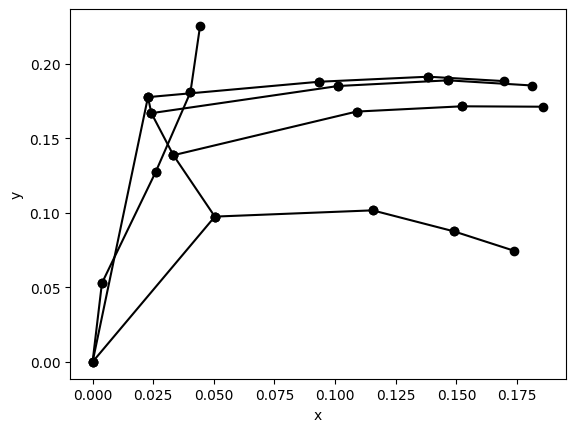

In [676]:
segmente = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]
ld = pd.DataFrame(X_train[72][50][:HAND_NUM])
ld = ld.rename(columns={0:'x', 1:'y', 2:'z'})
ld['y'] = -ld['y']
ld.plot(x='x', y='y', kind='scatter')

for seg in segmente:
    x_values = [ld.loc[seg[0], 'x'], ld.loc[seg[1], 'x']]
    y_values = [ld.loc[seg[0], 'y'], ld.loc[seg[1], 'y']]
    plt.plot(x_values, y_values, marker='o', color = 'k')
# X_train[0].shape

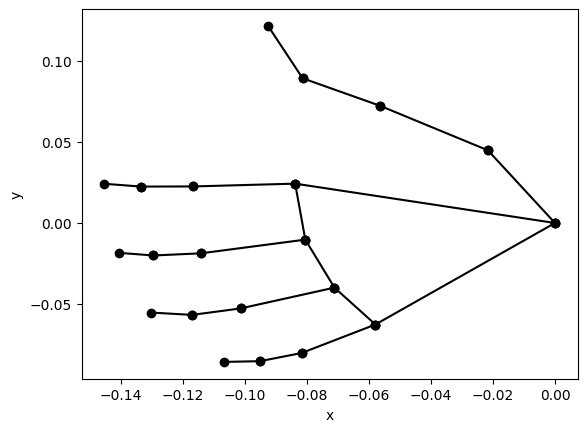

In [677]:
segmente = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]
ld = pd.DataFrame(X_train[73][50][:HAND_NUM])
ld = ld.rename(columns={0:'x', 1:'y', 2:'z'})
ld['y'] = -ld['y']
ld.plot(x='x', y='y', kind='scatter')

for seg in segmente:
    x_values = [ld.loc[seg[0], 'x'], ld.loc[seg[1], 'x']]
    y_values = [ld.loc[seg[0], 'y'], ld.loc[seg[1], 'y']]
    plt.plot(x_values, y_values, marker='o', color = 'k')
# X_train[0].shape

# Data Augmentation

In [653]:
def random_scale(data, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    data[:, :, :2] *= scale
    return data

def random_shift(data, shift_range=(0.1, 0.1)):
    shift_x = np.random.uniform(-shift_range[0], shift_range[0])
    shift_y = np.random.uniform(-shift_range[1], shift_range[1])
    data[:, :, 0] += shift_x
    data[:, :, 1] += shift_y
    return data

def random_rotate(data, angle_range=(-10, 10)):
    angle = np.random.uniform(angle_range[0], angle_range[1])
    radians = np.deg2rad(angle)
    cos_val = np.cos(radians)
    sin_val = np.sin(radians)
    
    x = data[:, :, 0]
    y = data[:, :, 1]
    
    data[:, :, 0] = cos_val * x - sin_val * y
    data[:, :, 1] = sin_val * x + cos_val * y
    return data

def random_shear(data, shear_range=(-10, 10)):
    shear = np.random.uniform(shear_range[0], shear_range[1])
    shear_radians = np.deg2rad(shear)
    
    x = data[:, :, 0]
    y = data[:, :, 1]
    
    data[:, :, 0] = x + shear_radians * y
    return data

In [654]:
def apply_augmentations(data):
    aug_functions = [random_scale, random_shift, random_rotate, random_shear]
    np.random.shuffle(aug_functions)
    for fun in aug_functions:
            data = fun(data)

    return data

In [655]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()
    
    if num == None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            if np.random.rand() < 0.3:
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [656]:
X_train, Y_train = augment(X_train, Y_train, 1)


100%|█████████████████████████████████████████████████████████| 1489/1489 [00:00<00:00, 5712.23it/s]


In [ ]:
def padding(X, Y, length=length, pad=0):
    X_padded = []
    for x in X:
        if len(x) >= 2 * length:  
            x = x[::2]  
        if len(x) > length:
            X_padded.append(x[:length])  # truncate if more than length
        else:
            pad =  np.expand_dims(x[0], axis=0)
            while(len(x) < length):
              x = np.concatenate((pad, x), axis = 0)
            X_padded.append(x)
            
    X_padded = np.array(X_padded)
    return X_padded, Y


In [658]:
gc.collect()

X_train, Y_train = padding(X_train, Y_train, length=length, pad=0)
X_val, Y_val = padding(X_val, Y_val, length=length, pad=0)
X_test, Y_test = padding(X_test, Y_test, length=length, pad=0)

In [659]:
X_train.shape

(1932, 82, 124, 3)

In [660]:
labels = np.unique(Y_train)
unique_labels = {word: idx for idx, word in enumerate(labels)}
print(labels)

['ACCIDENT' 'AFRICA' 'ALL' 'APPLE' 'BASKETBALL1' 'BED1' 'BEFORE' 'BIRD'
 'BIRTHDAY' 'BLACK' 'BLUE' 'BOOK' 'BOWLING1' 'BROWN' 'BUT' 'CAN1' 'CANDY1'
 'CHAIR' 'CHANGE' 'CHEAT1' 'CITY1' 'CLOTHES' 'COLOR' 'COMPUTER' 'COOK'
 'COOL1' 'CORN1' 'COUSIN' 'COW' 'DANCE' 'DARK1' 'DEAF1' 'DECIDE1'
 'DOCTOR1' 'DOG1' 'DRINK1' 'EAT1' 'ENJOY' 'FAMILY' 'FINE1' 'FINISH' 'FISH'
 'FULL' 'GIVE' 'GO' 'GRADUATE' 'HAT1' 'HEARING' 'HELP' 'HOT' 'HOW1'
 'JACKET1' 'KISS1' 'LANGUAGE' 'LAST' 'LATER' 'LETTER1' 'LIKE' 'MAN' 'MANY'
 'MEDICINE' 'MEET' 'MOTHER' 'NEED' 'NO' 'NOW' 'ORANGE' 'PAINT' 'PAPER'
 'PINK' 'PIZZA1' 'PLAY' 'PULL' 'PURPLE' 'RIGHT1' 'SAME1' 'SCHOOL'
 'SECRETARY' 'SHIRT1' 'SON' 'STUDY' 'TABLE' 'TALL1' 'TELL' 'THANKSGIVING'
 'THIN' 'THURSDAY' 'TIME' 'UNIVERSITY' 'WALK1' 'WANT1' 'WATER' 'WHAT1'
 'WHITE' 'WHO' 'WOMAN1' 'WORK' 'WRONG' 'YEAR' 'YES']


In [661]:
Y_train = np.array([unique_labels[word] for word in Y_train])
Y_val = np.array([unique_labels[word] for word in Y_val])
Y_test = np.array([unique_labels[word] for word in Y_test])

In [662]:
Y_train = to_categorical(Y_train).astype(int)
Y_val = to_categorical(Y_val).astype(int)
Y_test = to_categorical(Y_test).astype(int)

In [ ]:
def ploturiSiSave(history, nume):
    train_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    step = 3

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_acc, 'b-', label='Acuratețe antrenare', linewidth=1)
    plt.plot(epochs, val_acc, 'r-', label='Acuratețe validare', linewidth=1)
    plt.scatter(epochs[::step], train_acc[::step], color='blue', s=30)
    plt.scatter(epochs[::step], val_acc[::step], color='red', s=30)
    plt.title('Acuratețe antrenare și validare')
    plt.xlabel('Epocă')
    plt.ylabel('Acuratețe')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_loss, 'b-', label='Loss antrenare', linewidth=1)
    plt.plot(epochs, val_loss, 'r-', label='Loss validare', linewidth=1)
    plt.scatter(epochs[::step], train_loss[::step], color='blue', s=30)
    plt.scatter(epochs[::step], val_loss[::step], color='red', s=30)
    plt.title('Loss antrenare și validare')
    plt.xlabel('Epocă')
    plt.ylabel('Pierdere')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'/kaggle/working/{nume}.png')    
    plt.show()


# Transformer model

In [666]:
@register_keras_serializable(package="Custom", name="MyLayer")
class MyLayer(Layer):
    def call(self, x):
        return tf.reshape(x, [-1, X_train[0].shape[0], X_train[0].shape[1] * X_train[0].shape[2]])

In [ ]:
@register_keras_serializable(package="Custom", name="ECA")
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

@register_keras_serializable(package="Custom", name="CausalDWConv1D")
class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):

    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))

    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [668]:
@register_keras_serializable(package="Custom", name="MultiHeadSelfAttention")
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [ ]:
def get_model(max_len=length, dropout_step=0, dim=192):
    inp = tf.keras.layers.Input(X_train[0].shape, name='input')
    x = inp
    x = MyLayer()(x)

    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(0.8)(x)    

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inp, outputs=outputs) 

    return model

In [ ]:
model = get_model(length)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: float(lr * tf.math.exp(-0.1)) if epoch >= 50 else float(lr))

initial_learning_rate = 1e-3
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name=f'top{5}', dtype=None)]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_transformer.keras', monitor='val_categorical_accuracy', save_best_only=True, mode='max', verbose=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: float(lr * tf.math.exp(-0.1)) if epoch >= 50 else float(initial_learning_rate))
callbacks_list = [checkpoint, lr_scheduler]

In [ ]:
history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_val, Y_val), callbacks=callbacks_list, shuffle=True)

Epoch 1/100
 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - categorical_accuracy: 0.0039 - loss: 8.6824 - top5: 0.0312      

W0000 00:00:1718530490.171052     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530490.175361     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530490.177683     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530490.178997     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530490.180485     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530490.182076     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530490.183426     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530490.184766     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.0122 - loss: 7.6351 - top5: 0.0616  

W0000 00:00:1718530527.860060     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530527.861651     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530527.862276     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530527.862999     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530527.863817     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530527.864480     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530527.865467     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530527.867477     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_categorical_accuracy improved from -inf to 0.01809, saving model to best_model_transformer.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - categorical_accuracy: 0.0124 - loss: 7.6101 - top5: 0.0622 - val_categorical_accuracy: 0.0181 - val_loss: 4.5640 - val_top5: 0.0879 - learning_rate: 0.0010
Epoch 2/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.0318 - loss: 5.4426 - top5: 0.1082
Epoch 2: val_categorical_accuracy improved from 0.01809 to 0.05943, saving model to best_model_transformer.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - categorical_accuracy: 0.0322 - loss: 5.4291 - top5: 0.1091 - val_categorical_accuracy: 0.0594 - val_loss: 4.4154 - val_top5: 0.2171 - learning_rate: 0.0010
Epoch 3/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.0592 - loss: 4.8035 - top5: 0.1956
Epoch 3: val_categorical_accuracy improved from 0.05943 to 0.17313, saving model to best_model_transformer.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - 

In [672]:
# model.summary()
loaded_model = load_model('best_model_transformer.keras', custom_objects={"ECA": ECA, "MultiHeadSelfAttention":MultiHeadSelfAttention})
x = loaded_model.evaluate(X_test, Y_test)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer '79_dwconv', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'eca_78', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer '80_dwconv', however the layer does not have a `b

15/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.8240 - loss: 1.5368 - top5: 0.9371

W0000 00:00:1718530709.877203     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530709.878051     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530709.878634     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530709.879239     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530709.879896     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530709.880452     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718530709.881117     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - categorical_accuracy: 0.8132 - loss: 1.5542 - top5: 0.9337


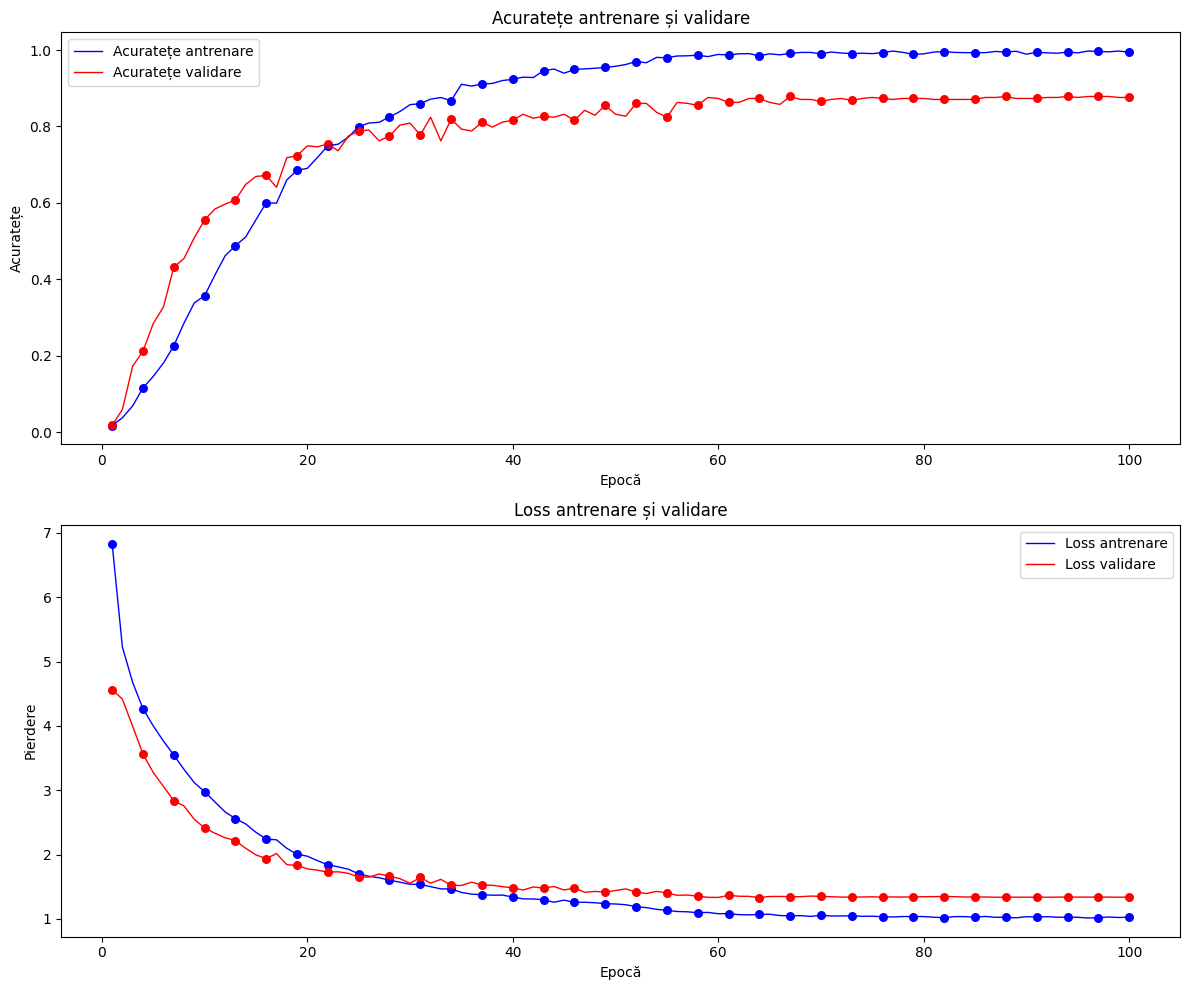

In [ ]:
ploturiSiSave(history, "transformerplot")

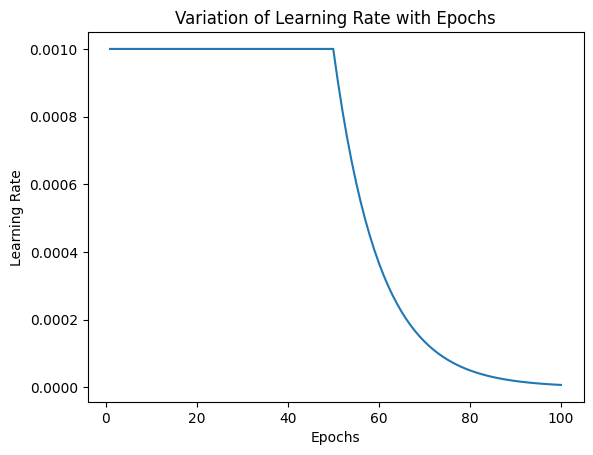

In [ ]:
def lr_scheduler(epoch, lr):
    return lr * np.exp(-0.1) if epoch >= 50 else lr

initial_lr = 1e-3  
num_epochs = 100 
lr = initial_lr
learning_rates = []
for epoch in range(num_epochs):
    lr = lr_scheduler(epoch, lr)
    learning_rates.append(lr)

epochs = np.arange(1, num_epochs + 1)
plt.plot(epochs, learning_rates)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Variation of Learning Rate with Epochs')
plt.show()


In [678]:
model.summary()

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 82, 124,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_13         │ (None, 82, 372)   │          0 │ input[0][0]       │
│ (MyLayer)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Dense)   │ (None, 82, 192)   │     71,424 │ my_layer_13[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 82, 192)   │        768 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 79_expand_conv      │ (None, 82, 384)   │     74,112 │ stem_bn[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 79_dwconv           │ (None, 82, 384)   │      6,528 │ 79_expand_conv[0… │
│ (CausalDWConv1D)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 79_bn               │ (None, 82, 384)   │      1,536 │ 79_dwconv[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eca_78 (ECA)        │ (None, 82, 384)   │          5 │ 79_bn[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 79_project_conv     │ (None, 82, 192)   │     73,920 │ eca_78[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 79_drop (Dropout)   │ (None, 82, 192)   │          0 │ 79_project_conv[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 79_add (Add)        │ (None, 82, 192)   │          0 │ 79_drop[0][0],    │
│                     │                   │            │ stem_bn[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 80_expand_conv      │ (None, 82, 384)   │     74,112 │ 79_add[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 80_dwconv           │ (None, 82, 384)   │      6,528 │ 80_expand_conv[0… │
│ (CausalDWConv1D)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 80_bn               │ (None, 82, 384)   │      1,536 │ 80_dwconv[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eca_79 (ECA)        │ (None, 82, 384)   │          5 │ 80_bn[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 80_project_conv     │ (None, 82, 192)   │     73,920 │ eca_79[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 80_drop (Dropout)   │ (None, 82, 192)   │          0 │ 80_project_conv[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 80_add (Add)        │ (None, 82, 192)   │          0 │ 80_drop[0][0],    │
│                     │                   │            │ 79_add[0][0]      │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,129,864 (19.57 MB)

 Trainable params: 1,707,778 (6.51 MB)

 Non-trainable params: 6,528 (25.50 KB)

 Optimizer params: 3,415,558 (13.03 MB)

# GRU model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, Reshape

def gru_bn(x, units, return_sequences=False):
    x = GRU(units, return_sequences=return_sequences, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def build_gru_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Reshape pentru a adăuga dimensiunea width
    x = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)  
    # Straturi GRU
    x = gru_bn(x, 64, return_sequences=True)
    x = Dropout(0.3)(x)
    x = gru_bn(x, 128, return_sequences=True)
    x = Dropout(0.3)(x)
    x = gru_bn(x, 256, return_sequences=True)
    
    # Global Average Pooling + Dense
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(0.8)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model



In [681]:
input_shape = (length, NUM_LANDMARKS, 3) 
num_classes = NUM_CLASSES
epochs = EPOCHS

# LearningRateScheduler
tf.random.set_seed(42)
model = build_gru_model(input_shape, num_classes)
initial_learning_rate = 1e-3
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name=f'top{5}', dtype=None)]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_gru.keras', monitor='val_categorical_accuracy', save_best_only=True, mode='max', verbose=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: float(lr * tf.math.exp(-0.1)) if epoch >= 50 else float(lr))
callbacks_list = [checkpoint, lr_scheduler]



In [682]:
model.summary()

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 82, 124, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_325 (Reshape)           │ (None, 82, 372)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_30 (GRU)                    │ (None, 82, 64)         │        83,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 82, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 82, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_31 (GRU)                    │ (None, 82, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 82, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 82, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_32 (GRU)                    │ (None, 82, 256)        │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 82, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_493    │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,844 (1.83 MB)

 Trainable params: 478,948 (1.83 MB)

 Non-trainable params: 896 (3.50 KB)

In [683]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=128, validation_data=(X_val, Y_val), callbacks=callbacks_list, shuffle=True)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - categorical_accuracy: 0.0152 - loss: 5.5995 - top5: 0.0558
Epoch 1: val_categorical_accuracy improved from -inf to 0.01292, saving model to best_model_gru.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 782ms/step - categorical_accuracy: 0.0151 - loss: 5.5880 - top5: 0.0560 - val_categorical_accuracy: 0.0129 - val_loss: 4.5925 - val_top5: 0.1240 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.0249 - loss: 4.8583 - top5: 0.0979
Epoch 2: val_categorical_accuracy improved from 0.01292 to 0.02326, saving model to best_model_gru.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - categorical_accuracy: 0.0251 - loss: 4.8538 - top5: 0.0982 - val_categorical_accuracy: 0.0233 - val_loss: 4.5686 - val_top5: 0.1370 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.0398 - loss: 4.5980 - top5: 0.1410
Epoch 3: val_categorical_accuracy improved from 0.02326

In [684]:
loaded_model = load_model('best_model_gru.keras')
x = loaded_model.evaluate(X_test, Y_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - categorical_accuracy: 0.7956 - loss: 1.6093 - top5: 0.9423


# LSTM model

In [686]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Reshape

def lstmblock(x, units, return_sequences=False):
    x = LSTM(units, return_sequences=return_sequences, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Reshape pentru a adăuga dimensiunea width
    x = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)  
    # Straturi GRU
    x = lstmblock(x, 64, return_sequences=True)
    x = Dropout(0.3)(x)
    x = lstmblock(x, 128, return_sequences=True)
    x = Dropout(0.3)(x)
    x = lstmblock(x, 256, return_sequences=True)
    
    # Global Average Pooling + Dense
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(0.8)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (length, NUM_LANDMARKS, 3) 
num_classes = NUM_CLASSES
epochs = EPOCHS

# LearningRateScheduler
tf.random.set_seed(42)
model = build_lstm_model(input_shape, num_classes)
initial_learning_rate = 1e-3
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name=f'top{5}', dtype=None)]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_lstm.keras', monitor='val_categorical_accuracy', save_best_only=True, mode='max', verbose=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: float(lr * tf.math.exp(-0.1)) if epoch >= 50 else float(lr))
callbacks_list = [checkpoint, lr_scheduler]

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=128, validation_data=(X_val, Y_val), callbacks=callbacks_list, shuffle=True)

Epoch 1/100
 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - categorical_accuracy: 0.0059 - loss: 5.7683 - top5: 0.0469 

W0000 00:00:1718531277.726863     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - categorical_accuracy: 0.0119 - loss: 5.4872 - top5: 0.0692
Epoch 1: val_categorical_accuracy improved from -inf to 0.00775, saving model to best_model_lstm.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 752ms/step - categorical_accuracy: 0.0122 - loss: 5.4754 - top5: 0.0700 - val_categorical_accuracy: 0.0078 - val_loss: 4.6042 - val_top5: 0.0879 - learning_rate: 0.0010
Epoch 2/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.0346 - loss: 4.6953 - top5: 0.1228
Epoch 2: val_categorical_accuracy improved from 0.00775 to 0.01550, saving model to best_model_lstm.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - categorical_accuracy: 0.0352 - loss: 4.6894 - top5: 0.1245 - val_categorical_accuracy: 0.0155 - val_loss: 4.6023 - val_top5: 0.0620 - learning_rate: 0.0010
Epoch 3/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.0645 - loss: 4.3892 - top5: 0.1904
Epoch 3: val_categorical_accuracy did not improve from 0.01550
16

In [ ]:
loaded_model = load_model('best_model_lstm.keras')
x = loaded_model.evaluate(X_test, Y_test)